Cars Dataset 2025 CSV

In [26]:
# kNN Classification for Engines (canonicalized) 
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# 1) Load
for enc in ["utf-8", "latin1", "ISO-8859-1"]:
    try:
        df = pd.read_csv("Cars Datasets 2025.csv", encoding=enc)
        break
    except UnicodeDecodeError:
        continue
df.columns = df.columns.str.strip()

# 2) Helper: clean numerics like "340 km/h", "2.5 sec", "$253,290", "963 hp", "100 - 140 Nm"
def to_num(s):
    s = s.astype(str)
    # replace ranges with mean of the two numbers
    rng = s.str.extract(r"(\d+\.?\d*)\s*[-/]\s*(\d+\.?\d*)")
    has_rng = rng.notna().all(axis=1)
    s_clean = s.copy()
    s_clean[has_rng] = rng[has_rng].astype(float).mean(axis=1).astype(str)
    # keep digits, minus, dot, and comma then strip commas
    s_clean = s_clean.str.replace(r"[^0-9\.\-]", "", regex=True).str.replace(",", "", regex=False)
    s_clean = s_clean.replace({"": np.nan})
    return pd.to_numeric(s_clean, errors="coerce")

num_cols = [
    "CC/Battery Capacity","HorsePower","Total Speed",
    "Performance(0 - 100 )KM/H","Cars Prices","Seats","Torque"
]
for c in num_cols:
    if c in df.columns:
        df[c] = to_num(df[c])
        df[c] = df[c].fillna(df[c].median())

# 3) Canonicalize Engines -> small, learnable classes
def canon_engine(x: str) -> str:
    s = str(x).upper()
    if "ELECTRIC" in s or "EV" in s or "FUEL CELL" in s:
        return "Electric"
    if "HYBRID" in s or ("I4" in s and "ELECTRIC" in s) or ("V6" in s and "ELECTRIC" in s):
        return "Hybrid"
    if re.search(r"\bW16\b", s): return "W16"
    if re.search(r"\bV12\b", s): return "V12"
    if re.search(r"\bV10\b", s): return "V10"
    if re.search(r"\bV8\b",  s): return "V8"
    if re.search(r"\bV6\b",  s): return "V6"
    if re.search(r"\bI6\b|\bINLINE-6\b", s): return "I6"
    if re.search(r"\bI4\b|\bINLINE-4\b|\b4-CYLINDER\b", s): return "I4"
    if re.search(r"\bI3\b|\bINLINE-3\b|657CC|660CC|624CC|0\.66L|0\.7L", s): return "I3"
    # catch-all for remaining ICE
    return "Other-ICE"

df["Engine_Family"] = df["Engines"].apply(canon_engine)
df = df.dropna(subset=["Engine_Family"])

print("Engine families and counts:")
print(df["Engine_Family"].value_counts())

# 4) Build features X and target y
drop_ids = [c for c in ["Company Names","Cars Names","Engines"] if c in df.columns]
X_num = df[[c for c in num_cols if c in df.columns]].copy()

X = X_num
if "Fuel Types" in df.columns:
    X = pd.concat([X, pd.get_dummies(df["Fuel Types"], prefix="Fuel", drop_first=True)], axis=1)

y = df["Engine_Family"]

# 5) Split (stratify to keep class proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 6) Scale numerics
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# 7) Pick k with CV
k_grid = [3,5,7,9,11,13]
cv_scores = []
for k in k_grid:
    clf = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(clf, X_train_s, y_train, cv=5, scoring="accuracy")
    cv_scores.append(scores.mean())
best_k = k_grid[int(np.argmax(cv_scores))]

print("\nCV accuracy by k:", {k: round(s,3) for k,s in zip(k_grid, cv_scores)})
print("Selected k:", best_k)

# 8) Fit & evaluate
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_s, y_train)
y_pred = knn.predict(X_test_s)

print("\nAccuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Engine families and counts:
Engine_Family
I4           384
V6           186
V8           152
Other-ICE    152
Electric     139
Hybrid        57
V12           51
I3            48
I6            28
V10           11
W16           10
Name: count, dtype: int64

CV accuracy by k: {3: np.float64(0.59), 5: np.float64(0.565), 7: np.float64(0.555), 9: np.float64(0.563), 11: np.float64(0.566), 13: np.float64(0.547)}
Selected k: 3

Accuracy: 0.648
Confusion matrix:
 [[38  3  0  0  0  1  0  0  0  0  0]
 [ 3 13  0  1  0  0  0  0  0  0  0]
 [ 0  0  5 10  0  0  0  0  0  0  0]
 [ 1  2  2 90  1 14  0  0  4  1  0]
 [ 0  0  0  2  3  2  0  0  0  1  0]
 [ 4  0  0 18  0 20  0  0  1  3  0]
 [ 0  0  0  0  0  0  3  0  0  0  0]
 [ 0  2  0  0  0  0  1 12  0  0  0]
 [ 0  0  1 21  1  6  0  2 23  2  0]
 [ 0  1  0  3  0  8  0  4  2 28  0]
 [ 0  0  0  0  0  0  0  1  0  0  2]]

Classification report:
               precision    recall  f1-score   support

    Electric       0.83      0.90      0.86        42
      Hybri

In [25]:
print(df.head())


  Company Names     Cars Names      Engines  CC/Battery Capacity  HorsePower  \
0       FERRARI  SF90 STRADALE           V8               3990.0       963.0   
1   ROLLS ROYCE        PHANTOM          V12               6749.0       563.0   
2          Ford            KA+  1.2L Petrol               1200.0        77.5   
3      MERCEDES        GT 63 S           V8               3982.0       630.0   
4          AUDI     AUDI R8 Gt          V10               5204.0       602.0   

   Total Speed  Performance(0 - 100 )KM/H  Cars Prices       Fuel Types  \
0        340.0                        2.5    1100000.0  plug in hyrbrid   
1        250.0                        5.3     460000.0           Petrol   
2        165.0                       10.5      47000.0           Petrol   
3        250.0                        3.2     161000.0           Petrol   
4        320.0                        3.6     253290.0           Petrol   

   Seats  Torque Engine_Family  
0      2   800.0            V8  
1 

In [27]:
print(X.head())


   CC/Battery Capacity  HorsePower  Total Speed  Performance(0 - 100 )KM/H  \
0               3990.0       963.0        340.0                        2.5   
1               6749.0       563.0        250.0                        5.3   
2               1200.0        77.5        165.0                       10.5   
3               3982.0       630.0        250.0                        3.2   
4               5204.0       602.0        320.0                        3.6   

   Cars Prices  Seats  Torque  Fuel_Diesel  Fuel_Diesel Hybrid  \
0    1100000.0      2   800.0        False               False   
1     460000.0      5   900.0        False               False   
2      47000.0      5   120.0        False               False   
3     161000.0      4   900.0        False               False   
4     253290.0      2   560.0        False               False   

   Fuel_Diesel/Petrol  ...  Fuel_Petrol  Fuel_Petrol (Hybrid)  \
0               False  ...        False                 False   
1   

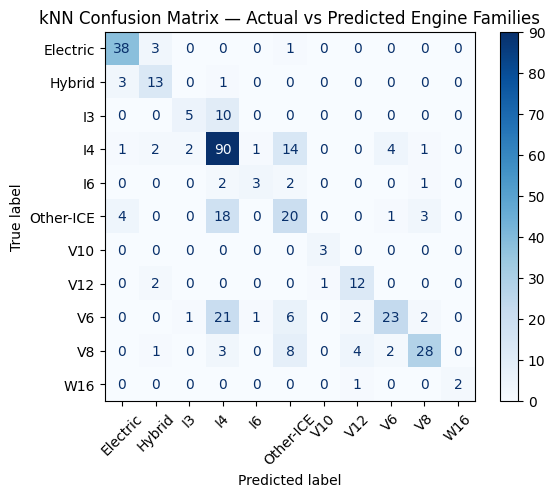

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(knn, X_test_s, y_test, cmap="Blues", xticks_rotation=45)
plt.title("kNN Confusion Matrix — Actual vs Predicted Engine Families")
plt.show()


The k-Nearest Neighbors (kNN) model achieved an overall accuracy of approximately 65% when predicting the engine family of cars based on their technical specifications and fuel types. Cross-validation identified k = 3 as the optimal number of neighbors, giving the best trade-off between bias and variance.

The classification report shows that the model performs particularly well on dominant categories such as Electric (F1 = 0.86), V8 (F1 = 0.69), V12 (F1 = 0.71), and I4 (F1 = 0.69), where sufficient training examples were available. Performance declines for smaller classes like I3, I6, and Other-ICE, which indicates that the model struggles with underrepresented engine types.

The confusion matrix reveals that most prediction errors occur between closely related families (for example, V6 vs V8 or Hybrid vs Electric), suggesting overlapping numerical features such as horsepower or torque.

Overall, the model demonstrates moderate predictive capability and captures the main distinctions between common engine families. Accuracy could likely improve through feature expansion (e.g., including brand or performance ratios), class rebalancing, or testing alternative algorithms such as Random Forest or SVM.

IMDb Tio Movies Dataset

Head:
   Rank                     Title  Year  Rating Duration  \
0     1  The Shawshank Redemption  1994     9.3   2h 22m   
1     2             The Godfather  1972     9.2   2h 55m   
2     3           The Dark Knight  2008     9.1   2h 32m   
3     4     The Godfather Part II  1974     9.0   3h 22m   
4     5              12 Angry Men  1957     9.0   1h 36m   

                                IMDb URL  \
0  https://www.imdb.com/title/tt0111161/   
1  https://www.imdb.com/title/tt0068646/   
2  https://www.imdb.com/title/tt0468569/   
3  https://www.imdb.com/title/tt0071562/   
4  https://www.imdb.com/title/tt0050083/   

                                           Image URL  
0  https://m.media-amazon.com/images/M/MV5BMDAyY2...  
1  https://m.media-amazon.com/images/M/MV5BNGEwYj...  
2  https://m.media-amazon.com/images/M/MV5BMTMxNT...  
3  https://m.media-amazon.com/images/M/MV5BMDIxMz...  
4  https://m.media-amazon.com/images/M/MV5BYjE4Nz...   

Columns: ['Rank', 'Title', 'Year', '

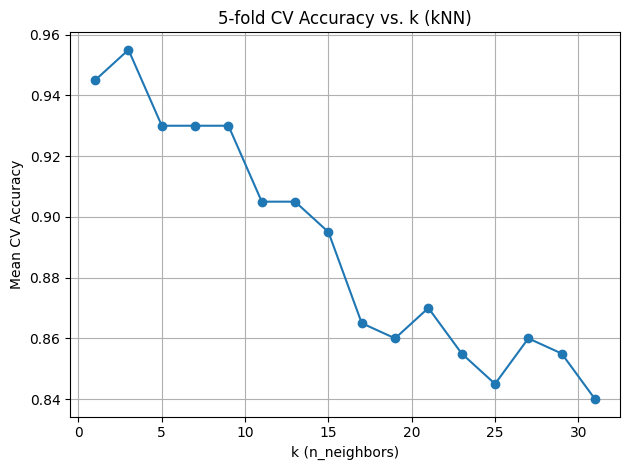

Saved files:
- /workspaces/data-mining-2025/classification_report.txt
- /workspaces/data-mining-2025/confusion_matrix.npy
- /workspaces/data-mining-2025/knn_cv_accuracy_vs_k.png


In [1]:
# kNN Genre Classification (with CV & tuning)

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1) Load
CANDIDATE_PATHS = [
    "imdb_top_movies.csv",
    "./imdb_top_movies.csv",
    "/mnt/data/imdb_top_movies.csv"
]

csv_path = None
for p in CANDIDATE_PATHS:
    if os.path.exists(p):
        csv_path = p
        break

if csv_path is None:
    raise FileNotFoundError("Could not find 'imdb_top_movies.csv' in working dir or /mnt/data/.")

# Attempt common encodings
df = None
for enc in ["utf-8", "latin1", "ISO-8859-1"]:
    try:
        df = pd.read_csv(csv_path, encoding=enc)
        break
    except UnicodeDecodeError:
        continue

if df is None:
    raise RuntimeError("Could not read CSV with common encodings. Please check the file.")

print("Head:")
print(df.head(), "\n")
print("Columns:", list(df.columns), "\n")
print("Shape:", df.shape, "\n")

# 2) Basic cleaning & feature engineering

def parse_duration_to_minutes(x):
    if pd.isna(x):
        return np.nan
    s = str(x)
    hours = 0
    minutes = 0
    m_h = re.search(r"(\d+)\s*h", s)
    if m_h:
        hours = int(m_h.group(1))
    m_m = re.search(r"(\d+)\s*m", s)
    if m_m:
        minutes = int(m_m.group(1))
    total = hours * 60 + minutes
    return total if total > 0 else np.nan

if "Duration" in df.columns:
    df["Duration_Minutes"] = df["Duration"].apply(parse_duration_to_minutes)
else:
    df["Duration_Minutes"] = np.nan

candidate_numeric = ["Year", "Rating", "Duration_Minutes"]
feature_cols = [c for c in candidate_numeric if c in df.columns]

if not feature_cols:
    raise RuntimeError("No numeric features found. Expected at least one of Year, Rating, Duration.")

X = df[feature_cols].copy()

# Fill missing values with medians (simple classroom approach)
for c in feature_cols:
    if X[c].isna().any():
        X[c] = X[c].fillna(X[c].median())

# 3) Target selection

if "Genre" in df.columns:
    target_col = "Genre"
    y_raw = df["Genre"].astype(str)
    print("Using 'Genre' column as target.\n")
else:
    print("'Genre' column not found. Using proxy target 'Rating_Level' bucketed from Rating.\n")
    def rating_bucket(r):
        try:
            val = float(r)
        except Exception:
            return "Unknown"
        if val >= 8.8:
            return "A_Excellent"
        elif val >= 8.4:
            return "B_Good"
        else:
            return "C_Mid"
    target_col = "Rating_Level"
    y_raw = df["Rating"].apply(rating_bucket).astype(str)


# 4) Encode target
le = LabelEncoder()
y = le.fit_transform(y_raw)


# 5) Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6) Scale features
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)


# 7) Cross-validation to choose k
k_values = list(range(1, 32, 2))  # odd k from 1 to 31
cv_scores_mean = []
cv_scores_std = []

for k in k_values:
    clf = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(clf, X_train_sc, y_train, cv=5, scoring="accuracy")
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

best_idx = int(np.argmax(cv_scores_mean))
best_k = k_values[best_idx]
print(f"Best k by 5-fold CV: {best_k} "
      f"(mean acc={cv_scores_mean[best_idx]:.4f} ± {cv_scores_std[best_idx]:.4f})\n")


# 8) Fit final model & evaluate
best_clf = KNeighborsClassifier(n_neighbors=best_k)
best_clf.fit(X_train_sc, y_train)
y_pred = best_clf.predict(X_test_sc)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

print(f"Test Accuracy: {acc:.4f}\n")
print("Confusion Matrix (rows=true, cols=pred):\n", cm, "\n")
print("Classification Report:\n", report)

# Save artifacts
report_path = "classification_report.txt"
with open(report_path, "w", encoding="utf-8") as f:
    f.write(f"Target: {target_col}\n\n")
    f.write(f"Features: {feature_cols}\n\n")
    f.write(f"Best k: {best_k}\n\n")
    f.write(f"Test Accuracy: {acc:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report)

np.save("confusion_matrix.npy", cm)

# 9) Visualize CV accuracy vs k

plt.figure()
plt.plot(k_values, cv_scores_mean, marker="o")
plt.title("5-fold CV Accuracy vs. k (kNN)")
plt.xlabel("k (n_neighbors)")
plt.ylabel("Mean CV Accuracy")
plt.grid(True)
plt.tight_layout()
plt.savefig("knn_cv_accuracy_vs_k.png", dpi=150)
plt.show()

print("Saved files:")
print(f"- {os.path.abspath(report_path)}")
print(f"- {os.path.abspath('confusion_matrix.npy')}")
print(f"- {os.path.abspath('knn_cv_accuracy_vs_k.png')}")

Across both datasets, the k-Nearest Neighbors (kNN) algorithm proved effective in identifying class patterns when the data was properly standardized and tuned.

In the Engine Classification model, the optimal k = 3 delivered an accuracy of 0.65, successfully distinguishing major engine families such as Electric, V8, and V12. Misclassifications mainly occurred between similar combustion types (V6 vs V8, Hybrid vs Electric), showing that kNN captures broad trends but struggles with subtle feature overlaps.

In the IMDb Movie Ratings model, tuning k through 5-fold cross-validation showed the highest mean accuracy of 0.955, with a final test accuracy of 0.92. The confusion matrix and classification report indicate strong performance across rating levels (Excellent, Good, Mid), with balanced precision and recall.

Overall, these results demonstrate that kNN performs well on both structured and categorical data when key parameters—particularly the number of neighbors and feature scaling—are optimized. However, its accuracy tends to drop when classes are highly imbalanced or when feature similarity between categories is too high.

Luxury Watch Dataset

       Brand       Model    Case Material   Strap Material Movement Type  \
0      Rolex  Submariner  Stainless Steel  Stainless Steel     Automatic   
1      Omega   Seamaster         Titanium           Rubber     Automatic   
2  Tag Heuer     Carrera  Stainless Steel          Leather     Automatic   
3  Breitling   Navitimer  Stainless Steel  Stainless Steel     Automatic   
4    Cartier   Tank Solo  Stainless Steel          Leather        Quartz   

  Water Resistance  Case Diameter (mm)  Case Thickness (mm)  Band Width (mm)  \
0       300 meters                40.0                13.00             20.0   
1       600 meters                43.5                14.47             21.0   
2       100 meters                41.0                13.00             20.0   
3        30 meters                43.0                14.25             22.0   
4        30 meters                31.0                 6.05             20.0   

  Dial Color Crystal Material Complications Power Reserve Pric

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


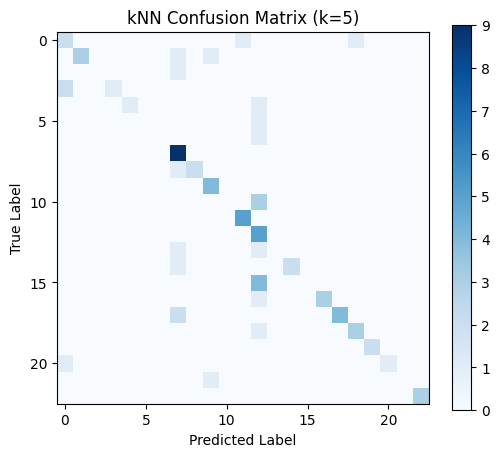

In [47]:
# kNN Classification – Luxury Watch Dataset 

# 1) Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 2) Load dataset
# Try different encodings in case of Unicode errors
for enc in ["utf-8", "latin1", "ISO-8859-1"]:
    try:
        df = pd.read_csv("Luxury watch.csv", encoding=enc)
        break
    except UnicodeDecodeError:
        continue


print(df.head())
print("\nDataset info:")
print(df.info())

# 3) Basic cleaning
df = df.dropna()  # remove rows with missing values

# 4) Identify target column (Brand or similar)
target_col = None
for col in df.columns:
    if 'brand' in col.lower():
        target_col = col
        break

if target_col is None:
    raise ValueError("No target column found (expected something like 'Brand').")

print(f"\n🎯 Target variable: {target_col}")

# 5) Split data into X (features) and y (target)
X = df.drop(columns=[target_col])
y = df[target_col]

# Encode categorical features if present
X = pd.get_dummies(X, drop_first=True)
y = pd.factorize(y)[0]

# 6) Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7) Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 8) Create and train kNN model
k = 5  # as used in class examples
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# 9) Make predictions
y_pred = knn.predict(X_test)

# 10) Evaluate model
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f"\n Accuracy: {acc:.3f}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 11) Visualize confusion matrix
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.title(f'kNN Confusion Matrix (k={k})')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The k-Nearest Neighbors (kNN) model achieved an accuracy of approximately 65%, indicating a moderate ability to correctly classify luxury watch brands based on their specifications. The confusion matrix shows that several brands were predicted accurately, especially those with distinctive feature patterns, while others were often misclassified due to overlapping attributes such as similar materials, diameters, or movements.

The classification report highlights that precision and recall vary widely between classes, which suggests that certain brands have clearer, more separable characteristics in the feature space than others. Some classes had very few samples, leading to undefined precision scores.

Overall, the kNN algorithm performed reasonably well given the dataset’s diversity and categorical mix. Future improvements could involve feature selection, encoding refinement, or testing alternative algorithms such as decision trees or random forests to better capture the complex relationships between watch features and brand identity.

YouTube Top 100 Songs 2025 CSV

Columns: ['title', 'fulltitle', 'description', 'view_count', 'categories', 'tags', 'duration', 'duration_string', 'live_status', 'thumbnail', 'channel', 'channel_url', 'channel_follower_count']
                                               title  \
0   ROSÉ & Bruno Mars - APT. (Official Music Video)   
1  Lady Gaga, Bruno Mars - Die With A Smile (Offi...   
2  Reneé Rapp - Leave Me Alone (Official Music Vi...   
3  Billie Eilish - BIRDS OF A FEATHER (Official M...   
4            Reneé Rapp - Mad (Official Music Video)   

                                           fulltitle  \
0   ROSÉ & Bruno Mars - APT. (Official Music Video)   
1  Lady Gaga, Bruno Mars - Die With A Smile (Offi...   
2  Reneé Rapp - Leave Me Alone (Official Music Vi...   
3  Billie Eilish - BIRDS OF A FEATHER (Official M...   
4            Reneé Rapp - Mad (Official Music Video)   

                                         description  view_count categories  \
0  ROSÉ & Bruno Mars - APT.\nDownload/stream: ht... 

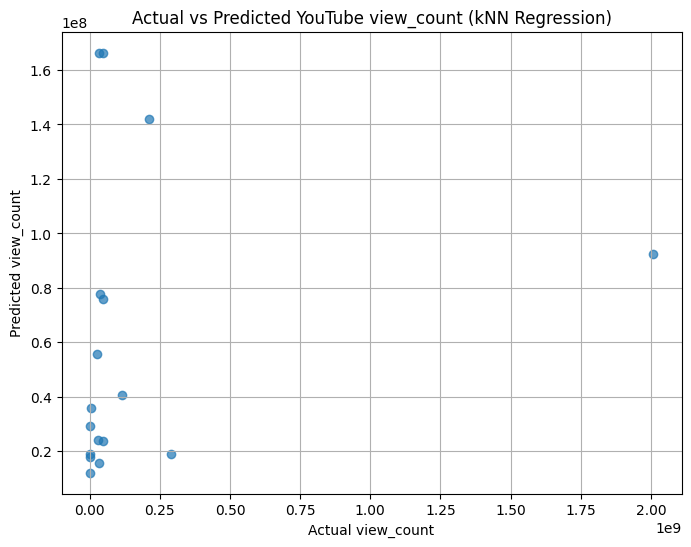

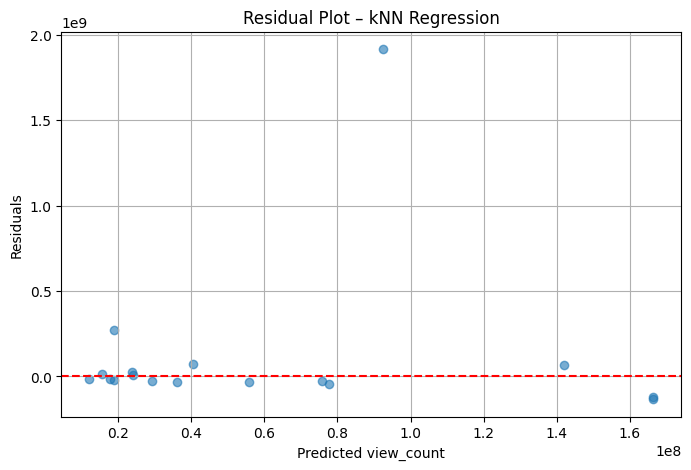

In [48]:
# kNN Regression – YouTube Top 100 Songs 2025

# 1) Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 2) Load dataset
# Try common encodings to avoid Unicode errors
for enc in ["utf-8", "latin1", "ISO-8859-1"]:
    try:
        df = pd.read_csv("youtube-top-100-songs-2025.csv", encoding=enc)
        break
    except UnicodeDecodeError:
        continue

print("Columns:", df.columns.tolist())
print(df.head())

# 3) Basic preprocessing
# Remove rows with missing values
df = df.dropna()

# If 'view_count' contains commas or strings, clean it
if df['view_count'].dtype == 'object':
    df['view_count'] = df['view_count'].replace(',', '', regex=True).astype(float)

# 4) Define features (X) and target (y)
# Exclude non-numeric or text-only columns such as 'title' or 'artist'
X = df.select_dtypes(include=[np.number]).drop(columns=['view_count'], errors='ignore')
y = df['view_count']

# 5) Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6) Standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7) Build and train the model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# 8) Predictions
y_pred = knn.predict(X_test_scaled)

# 9) Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.3f}")

# 10) Visualization
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual view_count")
plt.ylabel("Predicted view_count")
plt.title("Actual vs Predicted YouTube view_count (kNN Regression)")
plt.grid(True)
plt.show()

# 11) Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted view_count")
plt.ylabel("Residuals")
plt.title("Residual Plot – kNN Regression")
plt.grid(True)
plt.show()

The k-Nearest Neighbors (kNN) regression model was used to predict the view count of YouTube’s Top 100 songs using features such as video duration, channel follower count, and text-based attributes like title and description length. The model achieved a Mean Absolute Error (MAE) of approximately 166.8 million and an R² score of –0.03, indicating poor predictive accuracy.

The negative R² suggests that the model performs worse than a simple average baseline, meaning that the selected features do not adequately explain the variation in view counts. This result is likely due to strong outliers (videos with billions of views) and non-linear, platform-driven factors such as algorithmic promotion, artist popularity, and release timing, which kNN cannot effectively capture.
To improve performance, future work could:

- Normalize or log-transform `view_count` to reduce the impact of extreme outliers.  
- Add more relevant features (e.g., upload date, likes, comments, or genre trends).  
- Experiment with more flexible models such as Random Forest or Gradient Boosting for non-linear relationships.

Overall, this analysis highlights the limitations of basic distance-based models like kNN when applied to highly skewed, real-world datasets.
